In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn import init
from transformers import AutoTokenizer, AutoModel
import re
from utils.custom_dataset import TokenizedTextDataset
from utils.metrics import MetricsWriter, Metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
dataset = pd.read_csv('dataset/IMDB_preprocessed_v2.csv')
data = dataset[['review_final', 'sentiment']].copy()
data['label'] = data['sentiment'].map({'negative': 0, 'positive': 1})

In [3]:
class_counts = data['label'].value_counts()

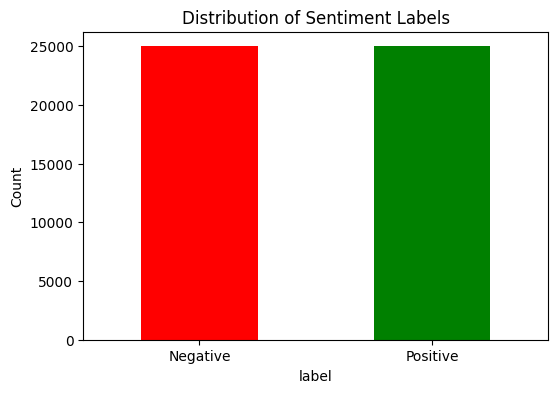

In [4]:
plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color=['red', 'green'])
plt.xticks(ticks=[0,1], labels=['Negative', 'Positive'], rotation=0)
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.show()

Дизбалансу класів немає тому можна використовувати звичайну BCE а не Focal loss

# Trim reviews

In [5]:
def trim_review(text, max_words=400):
    words = text.split()
    if len(words) <= max_words:
        return text
    if len(words) > (max_words + 50): # якщо . ! ? немає
        return " ".join(words[:max_words])
    
    trimmed = words[:max_words]
    for w in words[max_words:]:
        trimmed.append(w)
        if re.search(r'[.!?]$', w):
            break
    return " ".join(trimmed)

In [6]:
data['review_final'] = data['review_final'].apply(trim_review)

In [7]:
word_counts = data["review_final"].str.split().str.len()

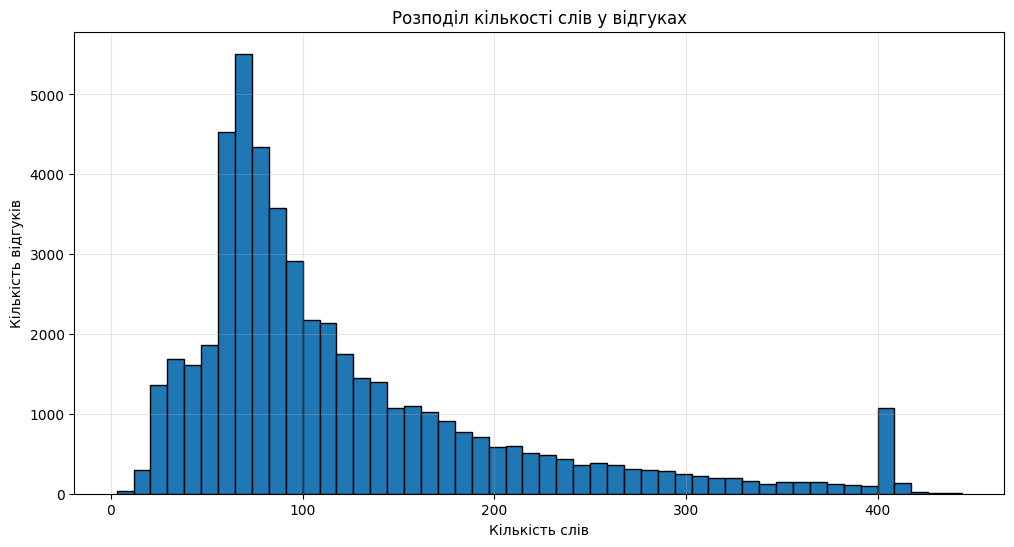

In [8]:
plt.figure(figsize=(12, 6))
plt.hist(word_counts, bins=50, edgecolor='black')
plt.title("Розподіл кількості слів у відгуках")
plt.xlabel("Кількість слів")
plt.ylabel("Кількість відгуків")
plt.grid(alpha=0.3)
plt.show()

In [9]:
views = data['review_final'].tolist()
y = data['label'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(views, y, test_size=0.2, random_state=42, stratify=y)

# Pretokenization

In [11]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
encoded_input_train = tokenizer(X_train, padding=True, truncation=True,
                          max_length=256, return_tensors='pt')
encoded_input_test = tokenizer(X_test, padding=True, truncation=True,
                          max_length=256, return_tensors='pt')

# Model

In [12]:
class MiniLMSentimentClassifier(nn.Module):
    def __init__(self,
        model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
        dropout_p: float = 0.2,
        device: str = "cuda"):
        super().__init__()

        self.device = device
        self.encoder = AutoModel.from_pretrained(model_name)

        embedding_dim = self.encoder.config.hidden_size  # 384 for MiniLM
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(embedding_dim, 1)
        self.init_weights()

    def init_weights(self):
        for layer in [self.fc1]:   # Xavier для нових Linear-шарів
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0.0)

    def get_info(self):
        return 'all-MiniLM-L6-v2', 'Fine-tuning'

    @staticmethod
    def mean_pooling(token_embeddings: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, input_ids, token_type_ids, attention_mask) -> torch.Tensor:
        model_output = self.encoder(input_ids=input_ids,
                                    attention_mask=attention_mask,
                                    token_type_ids=token_type_ids)

        # mean pooling з attention_mask
        token_embeddings = model_output.last_hidden_state  # (batch, seq_len, hidden_size)
        sentence_embeddings = self.mean_pooling(token_embeddings, attention_mask)
        sentence_embeddings = self.dropout(sentence_embeddings)
        return self.fc1(sentence_embeddings)

# Train func

In [13]:
import time
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [14]:
train_dataset = TokenizedTextDataset(encoded_input_train, y_train)
test_dataset = TokenizedTextDataset(encoded_input_test, y_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=4)

In [15]:
def train_step(model, loss_fn, opt, loader):
    loss_per_batches = 0
    start_epoch2 = time.time()

    for i, data in enumerate(tqdm(loader, desc="Training", total=len(loader))):
        input_ids = data["input_ids"].to(model.device)
        attention_mask = data["attention_mask"].to(model.device)
        token_type_ids = (data["token_type_ids"].to(model.device)
                          if "token_type_ids" in data else None) 
        labels = data["labels"].to(model.device)
        opt.zero_grad()

        y_pred = model(input_ids, token_type_ids, attention_mask)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        loss_per_batches += loss.item()

    print("train + load = " + str(time.time() - start_epoch2))
    return loss_per_batches/(i+1)  

In [16]:
def train(model, mw, loss_fn, opt, train_loader, val_loader, epochs=20):
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-6)

    for epoch in range(epochs):
        mw.print_epoch(epoch + 1)
        metrics_valid = Metrics()

        model.train()
        avg_loss = train_step(model, loss_fn, opt, train_loader)
        model.eval()

        vloss = 0
        counter = 0
        with torch.inference_mode():
            for i, vdata in enumerate(val_loader):
                vinput_ids = vdata["input_ids"].to(model.device)
                vattention_mask = vdata["attention_mask"].to(model.device)
                vtoken_type_ids = (vdata["token_type_ids"].to(model.device)
                                  if "token_type_ids" in vdata else None)
                vlabels = vdata["labels"].to(model.device)
                
                y_pred = model(vinput_ids, vtoken_type_ids, vattention_mask)
                bloss = loss_fn(y_pred, vlabels)
                vloss += bloss.item()

                probs = torch.sigmoid(y_pred)
                y_pred = (probs > 0.5).long()
                metrics_valid.batch_step(vlabels, y_pred)
                counter = i

        avg_vloss = vloss / (counter + 1)

        scheduler.step()

        valrecall, valprecision, valf1, valacc = metrics_valid.get_metrics()
        mw.writer_step(avg_loss, avg_vloss, valrecall, valprecision, valf1, valacc)
        mw.save_model(model)
        mw.print_time()

# Train model

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
model = MiniLMSentimentClassifier(dropout_p=0.2, device=device)
model = model.to(device)

In [19]:
for p in model.encoder.parameters():
    p.requires_grad = False

for layer in model.encoder.encoder.layer[-2:]:
    print(layer)
    for p in layer.parameters():
        p.requires_grad = True

BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=384, out_features=384, bias=True)
      (key): Linear(in_features=384, out_features=384, bias=True)
      (value): Linear(in_features=384, out_features=384, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=384, out_features=384, bias=True)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=384, out_features=1536, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=1536, out_features=384, bias=True)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
 

In [20]:
loss_fn = nn.BCEWithLogitsLoss()

In [21]:
no_decay = ["bias", "LayerNorm.weight"]

encoder_decay = []
encoder_no_decay = []

for name, param in model.encoder.named_parameters():
    if not param.requires_grad:
        continue                      # скіп заморожених

    if any(nd in name for nd in no_decay):
        encoder_no_decay.append(param)
    else:
        encoder_decay.append(param)

optimizer = torch.optim.AdamW([
    {"params": encoder_decay, "lr": 2e-5, "weight_decay": 0.01},
    {"params": encoder_no_decay, "lr": 2e-5, "weight_decay": 0.0},
    {"params": model.fc1.parameters(), "lr": 1e-4, "weight_decay": 1e-2},
])

In [22]:
mw = MetricsWriter(model, model_name='Fine_tune_last2_layers_1fc_v2', save_treshold=1)

In [23]:
train(model, mw, loss_fn, optimizer, train_dataloader, val_dataloader, epochs=10)

EPOCH 1:


Training: 100%|██████████████████████████████████████████████████████████████████████| 625/625 [05:33<00:00,  1.87it/s]


train + load = 333.44029092788696
LOSS train 0.38087648849487304 valid 0.29729236121390273
Accuracy valid 0.8786
Recall valid 0.8912
Precision valid 0.869293796332423
Val F1->0.8801106063598657
Time per epoch 392.8842716217041s
EPOCH 2:


Training: 100%|██████████████████████████████████████████████████████████████████████| 625/625 [05:30<00:00,  1.89it/s]


train + load = 330.28550839424133
LOSS train 0.300510652923584 valid 0.2970035226102088
Accuracy valid 0.8772
Recall valid 0.8272
Precision valid 0.9191111111111111
Val F1->0.8707368421052631
Time per epoch 389.2074325084686s
EPOCH 3:


Training: 100%|██████████████████████████████████████████████████████████████████████| 625/625 [05:30<00:00,  1.89it/s]


train + load = 330.5384304523468
LOSS train 0.2809383196592331 valid 0.27822962816163993
Accuracy valid 0.8829
Recall valid 0.9306
Precision valid 0.8495526748219828
Val F1->0.8882313639400592
Time per epoch 393.78492617607117s
EPOCH 4:


Training: 100%|██████████████████████████████████████████████████████████████████████| 625/625 [05:49<00:00,  1.79it/s]


train + load = 349.05819940567017
LOSS train 0.267171767115593 valid 0.2604193453481243
Accuracy valid 0.8931
Recall valid 0.8914
Precision valid 0.894441099739113
Val F1->0.892917960532906
Time per epoch 410.80908250808716s
EPOCH 5:


Training: 100%|██████████████████████████████████████████████████████████████████████| 625/625 [05:43<00:00,  1.82it/s]


train + load = 343.98612093925476
LOSS train 0.2528828684210777 valid 0.2610912254186952
Accuracy valid 0.8918
Recall valid 0.87
Precision valid 0.9096612296110415
Val F1->0.8893886730729912
Time per epoch 405.930278301239s
EPOCH 6:


Training: 100%|██████████████████████████████████████████████████████████████████████| 625/625 [05:47<00:00,  1.80it/s]


train + load = 347.1288387775421
LOSS train 0.24467139621973039 valid 0.25295850919310453
Accuracy valid 0.8933
Recall valid 0.9026
Precision valid 0.8861182014529747
Val F1->0.894283166551075
Time per epoch 408.761825799942s
EPOCH 7:


Training: 100%|██████████████████████████████████████████████████████████████████████| 625/625 [05:39<00:00,  1.84it/s]


train + load = 339.09576296806335
LOSS train 0.23734537134170533 valid 0.2559355921141661
Accuracy valid 0.8948
Recall valid 0.8772
Precision valid 0.9092039800995025
Val F1->0.8929153094462541
Time per epoch 398.0850718021393s
EPOCH 8:


Training: 100%|██████████████████████████████████████████████████████████████████████| 625/625 [05:32<00:00,  1.88it/s]


train + load = 332.95906138420105
LOSS train 0.23038513296842575 valid 0.25432130400162595
Accuracy valid 0.8958
Recall valid 0.8874
Precision valid 0.9025630593978845
Val F1->0.8949173053650665
Time per epoch 392.43861961364746s
EPOCH 9:


Training: 100%|██████████████████████████████████████████████████████████████████████| 625/625 [05:29<00:00,  1.89it/s]


train + load = 329.91172194480896
LOSS train 0.22639492099285125 valid 0.2521965810257918
Accuracy valid 0.8972
Recall valid 0.9016
Precision valid 0.893735130848533
Val F1->0.8976503385105535
Time per epoch 388.6589586734772s
EPOCH 10:


Training: 100%|██████████████████████████████████████████████████████████████████████| 625/625 [05:28<00:00,  1.90it/s]


train + load = 328.4120078086853
LOSS train 0.22517298593521118 valid 0.2523987042676112
Accuracy valid 0.8971
Recall valid 0.8894
Precision valid 0.9033109892342068
Val F1->0.8963015217172227
Time per epoch 387.14938950538635s
